In [1]:
import os,sys,inspect
import random

import renderer


currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

import util

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

import ipywidgets as widgets
from ipywidgets.widgets.interaction import interact


# Use interactive matplotlib backend, which runs in the browser
#%matplotlib notebook

------------------------------------

# 3D Solver - Pointsource test

In [2]:
sigma_t = 8.0
albedo = 0.9
size = 2.0
pointsource_center = np.array([1.0, 1.0, 1.0])

def grosjean(r, sigma_t, albedo):
    sigma_a = (1.0-albedo)*sigma_t
    sigma_s = albedo*sigma_t
    ss = np.exp(-sigma_t*r)/(4.0*np.pi*r*r)
    tmp = sigma_a+sigma_s
    D = (2.0*sigma_a+sigma_s)/(3.0*tmp*tmp)
    ms = 3.0*sigma_s*sigma_t*np.exp(-np.sqrt(sigma_a/D)*r)/(4.0*np.pi*(2.0*sigma_a+sigma_s)*r)
    #return ss+ms
    return ms

def cda_org( r, sigma_t, albedo ):
    sigma_a = (1.0-albedo)*sigma_t
    sigma_tr = np.sqrt(3.0*sigma_a*sigma_t)
    return 3.0*sigma_t*np.exp(-sigma_tr*r)/(4.0*np.pi*r)


In [2]:
pns_cda = renderer.load_pnsolution( "c:/projects/epfl/epfl17/python/pnsolver/results/pointsource/pointsource_cda2.pns" )
pns_p1 = renderer.load_pnsolution( "c:/projects/epfl/epfl17/python/pnsolver/results/pointsource/pointsource_p1_2.pns" )
pns_p2 = renderer.load_pnsolution( "c:/projects/epfl/epfl17/python/pnsolver/results/pointsource/pointsource_p2_2.pns" )
pns_p3 = renderer.load_pnsolution( "c:/projects/epfl/epfl17/python/pnsolver/results/pointsource/pointsource_p3_2.pns" )
pns_p4 = renderer.load_pnsolution( "c:/projects/epfl/epfl17/python/pnsolver/results/pointsource/pointsource_p4_2.pns" )
pns_p5 = renderer.load_pnsolution( "c:/projects/epfl/epfl17/python/pnsolver/results/pointsource/pointsource_p5_2.pns" )

In [4]:
r_list = np.linspace(1.0e-2, size*0.5, 100)
fluence_grosjean = [ grosjean(r, sigma_t, albedo) for r in r_list ]
fluence_cda = [ cda_org(r, sigma_t, albedo) for r in r_list ]

fluence_cda_numerical = np.array([pns_cda.evalCoefficient(pointsource_center+np.array([r, 0.0, 0.0]), 0) for r in r_list])
fluence_p1_numerical = np.array([pns_p1.evalCoefficient(pointsource_center+np.array([r, 0.0, 0.0]), 0) for r in r_list])
fluence_p2_numerical = np.array([pns_p2.evalCoefficient(pointsource_center+np.array([r, 0.0, 0.0]), 0) for r in r_list])
fluence_p3_numerical = np.array([pns_p3.evalCoefficient(pointsource_center+np.array([r, 0.0, 0.0]), 0) for r in r_list])
fluence_p4_numerical = np.array([pns_p4.evalCoefficient(pointsource_center+np.array([r, 0.0, 0.0]), 0) for r in r_list])
fluence_p5_numerical = np.array([pns_p5.evalCoefficient(pointsource_center+np.array([r, 0.0, 0.0]), 0) for r in r_list])


# Plotting fluence from PN against groundtruth

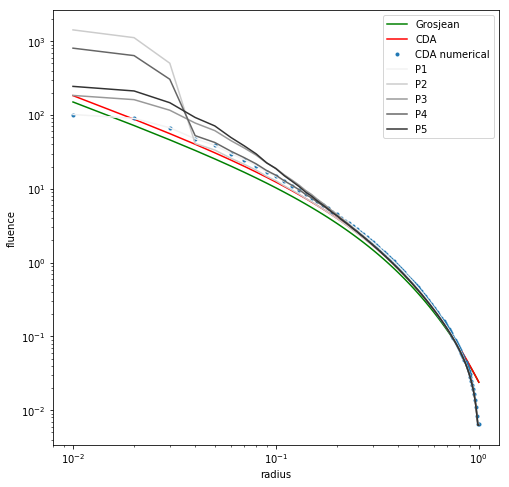

In [9]:
fig = plt.figure(figsize=(8,8));
ax = fig.add_subplot(111)
plt.loglog(r_list, fluence_grosjean, label="Grosjean", color="g")
plt.loglog(r_list, fluence_cda, label="CDA", color="r")
plt.loglog(r_list, fluence_cda_numerical, label="CDA numerical", marker=".", linestyle=" " )
plt.loglog(r_list, fluence_p1_numerical, label="P1", marker=" ", linestyle="-", color=".95" )
plt.loglog(r_list, fluence_p2_numerical, label="P2", marker=" ", linestyle="-", color=".8" )
plt.loglog(r_list, fluence_p3_numerical, label="P3", marker=" ", linestyle="-", color=".6" )
plt.loglog(r_list, fluence_p4_numerical, label="P4", marker=" ", linestyle="-", color=".4" )
plt.loglog(r_list, fluence_p5_numerical, label="P5", marker=" ", linestyle="-", color=".2" )
plt.xlabel('radius')
plt.ylabel('fluence')
plt.legend()
plt.show()

In [2]:
def plot_spherical_function( fun, vmin=-0.5, vmax=0.5 ):
    # plot sh functions
    theta = np.arange(0.0, 1.0, 0.01)*np.pi
    phi = np.arange(0.0, 1.0, 0.01)*2.0*np.pi

    f_img = np.zeros((theta.shape[0], phi.shape[0]))
    for j in range(phi.shape[0]):
        for i in range(theta.shape[0]):
            f_img[i, j] = fun(theta[i], phi[j])
    #return plt.imshow(f_img, interpolation="nearest", cmap='jet', vmin=vmin, vmax=vmax)
    #vmin = np.min(f_img)
    #vmax = np.max(f_img)
    #print("vmin={} vmax={}".format(vmin, vmax))
    return f_img
    #return plt.imshow(f_img, origin='lower',zorder=1, interpolation="nearest", cmap='jet', vmin=vmin, vmax=vmax, extent=[0.0,2.0*np.pi,0.0,np.pi])


def clamped_sh( pns, theta, phi ):
    # NB: the negative direction...
    value = pns.eval(pWS, -util.sphericalDirection(theta, phi))
    if value < 0.0:
        value = 0.0
    return value

def lookup_envmap( image, theta, phi ):
    uv = np.array([phi/(2.0*np.pi), theta/np.pi])
    pRaster = image.uvToRaster(uv)
    return image.eval( pRaster )[0]


In [6]:
pns_solutions = [pns_p1, pns_p2, pns_p3, pns_p4, pns_p5]
image_radiance_at_pWS = renderer.load_image("c:/projects/epfl/epfl17/python/pnsolver/results/pointsource/L_at_1.1.exr")
img_groundtruth = plot_spherical_function( lambda theta, phi: lookup_envmap(image_radiance_at_pWS, theta, phi) )

----------------------------------------

# Plotting radiance field at $r=0.1$ for groundtruth (left) and PN (right)

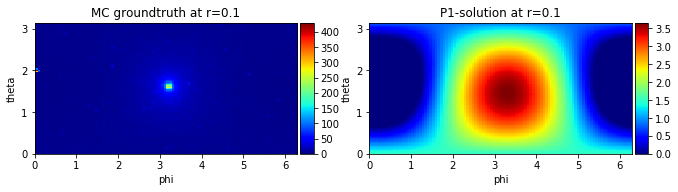

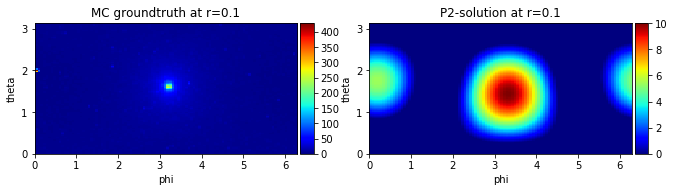

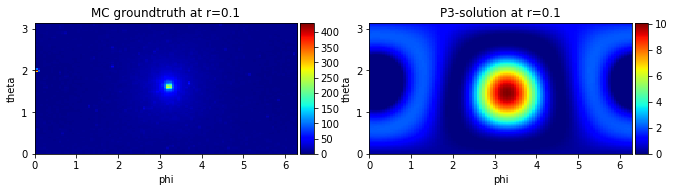

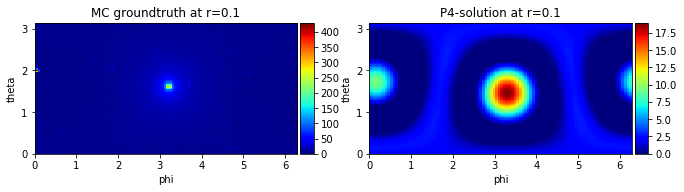

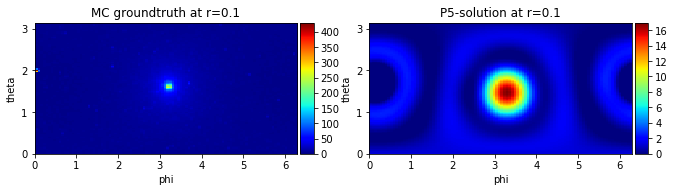

In [8]:
pWS = np.array([1.1, 1.0, 1.0])

for i in range(len(pns_solutions)):
    pns = pns_solutions[i]
    #pns = renderer.load_pnsolution( "results/pointsource/pointsource_p{}.pns".format(i+1) )

    fig = plt.figure(figsize=(11,11));
    ax = fig.add_subplot(121)
    plt.title("MC groundtruth at r=0.1")

    img_view = plt.imshow(img_groundtruth, origin='lower',zorder=1, interpolation="nearest", cmap='jet', vmin=0.0, vmax=np.max(img_groundtruth), extent=[0.0,2.0*np.pi,0.0,np.pi])
    plt.xlabel('phi')
    plt.ylabel('theta')

    #plt.scatter(samples_phi, samples_theta, c='r', label="sdda",zorder=2, marker='.', s=1.0)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(img_view, cax=cax)

    ax = fig.add_subplot(122)
    plt.title("P{}-solution at r=0.1".format(i+1))
    img = plot_spherical_function( lambda theta, phi: clamped_sh(pns, theta, phi) )
    img_view = plt.imshow(img, origin='lower',zorder=1, interpolation="nearest", cmap='jet', vmin=np.min(img), vmax=np.max(img), extent=[0.0,2.0*np.pi,0.0,np.pi])
    plt.xlabel('phi')
    plt.ylabel('theta')

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(img_view, cax=cax)

    plt.show()

----------------------------------------

# Filtering SH coefficients to reduce ringing using Hanning window (middle) and Lanzcos (right) for varying filter widths


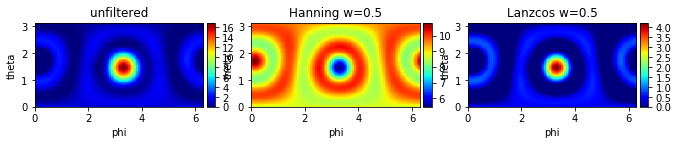

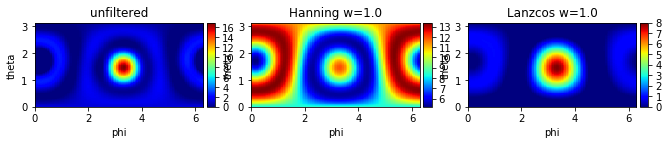

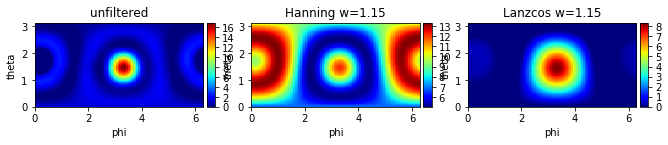

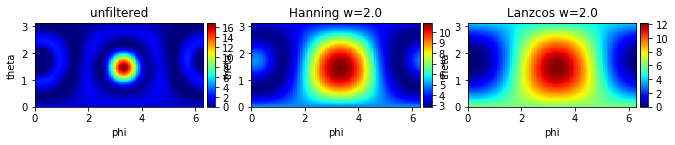

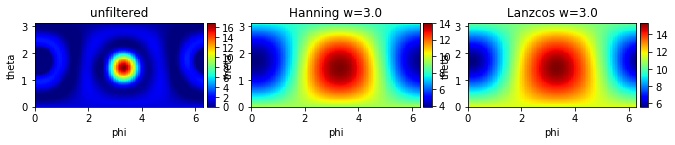

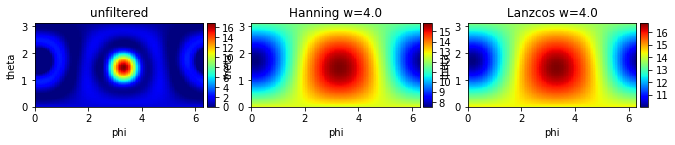

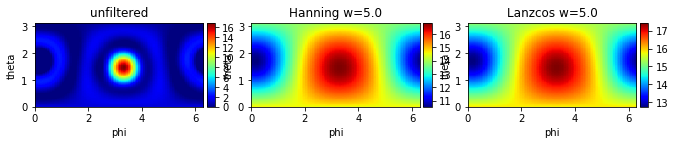

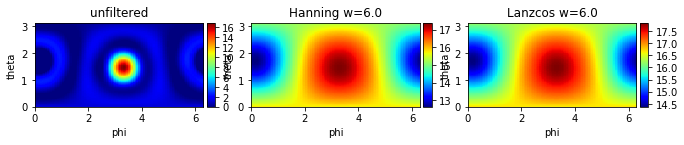

In [9]:
pns = pns_solutions[4]
for w in [0.5, 1.0, 1.15, 2.0, 3.0, 4.0, 5.0, 6.0]:
    #pns = renderer.load_pnsolution( "results/pointsource/pointsource_p{}.pns".format(i+1) )

    # unfiltered
    pns.setFilter( "none", w )
    
    fig = plt.figure(figsize=(11,11));
    ax = fig.add_subplot(131)
    plt.title("unfiltered")
    img = plot_spherical_function( lambda theta, phi: clamped_sh(pns, theta, phi) )
    img_view = plt.imshow(img, origin='lower',zorder=1, interpolation="nearest", cmap='jet', vmin=np.min(img), vmax=np.max(img), extent=[0.0,2.0*np.pi,0.0,np.pi])
    plt.xlabel('phi')
    plt.ylabel('theta')

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(img_view, cax=cax)
    
    pns.setFilter( "hanning", w )
    
    ax = fig.add_subplot(132)
    plt.title("Hanning w={}".format(w))
    img = plot_spherical_function( lambda theta, phi: clamped_sh(pns, theta, phi) )
    img_view = plt.imshow(img, origin='lower',zorder=1, interpolation="nearest", cmap='jet', vmin=np.min(img), vmax=np.max(img), extent=[0.0,2.0*np.pi,0.0,np.pi])
    plt.xlabel('phi')
    plt.ylabel('theta')

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(img_view, cax=cax)

    pns.setFilter( "lanzcos", w )
    
    ax = fig.add_subplot(133)
    plt.title("Lanzcos w={}".format(w))
    img = plot_spherical_function( lambda theta, phi: clamped_sh(pns, theta, phi) )
    img_view = plt.imshow(img, origin='lower',zorder=1, interpolation="nearest", cmap='jet', vmin=np.min(img), vmax=np.max(img), extent=[0.0,2.0*np.pi,0.0,np.pi])
    plt.xlabel('phi')
    plt.ylabel('theta')

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(img_view, cax=cax)
    
    plt.show()
pns.setFilter( "none", w )

----------------------------------------

# Sampling directions at random points within the volume using SH coefficients from PN-solution 

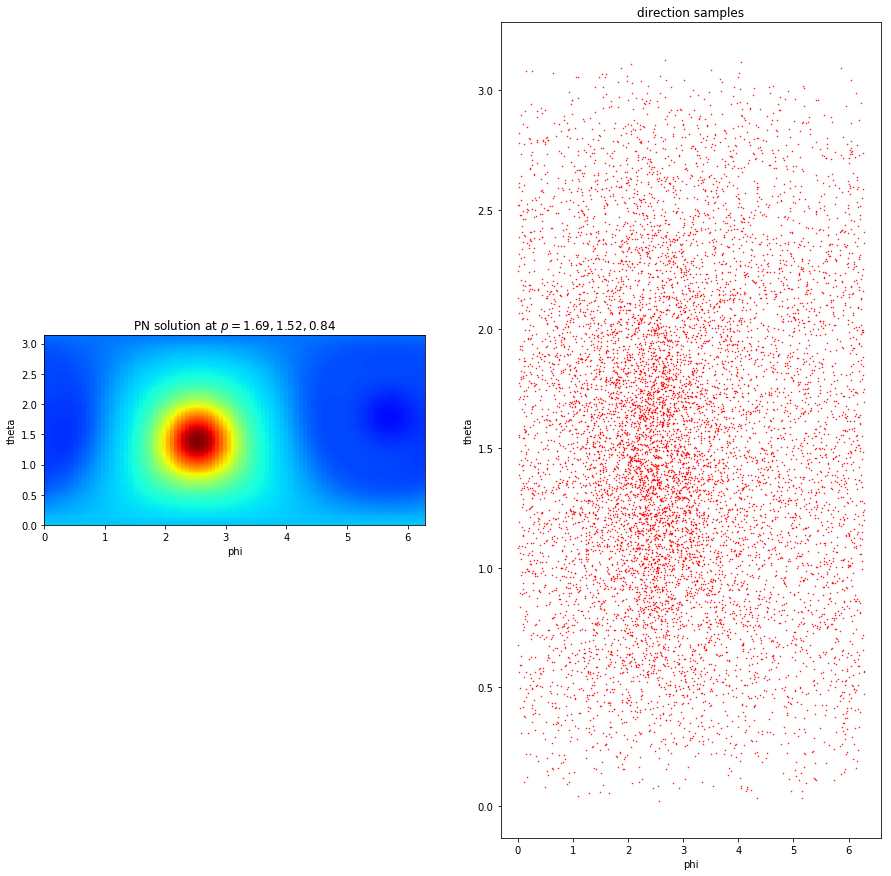

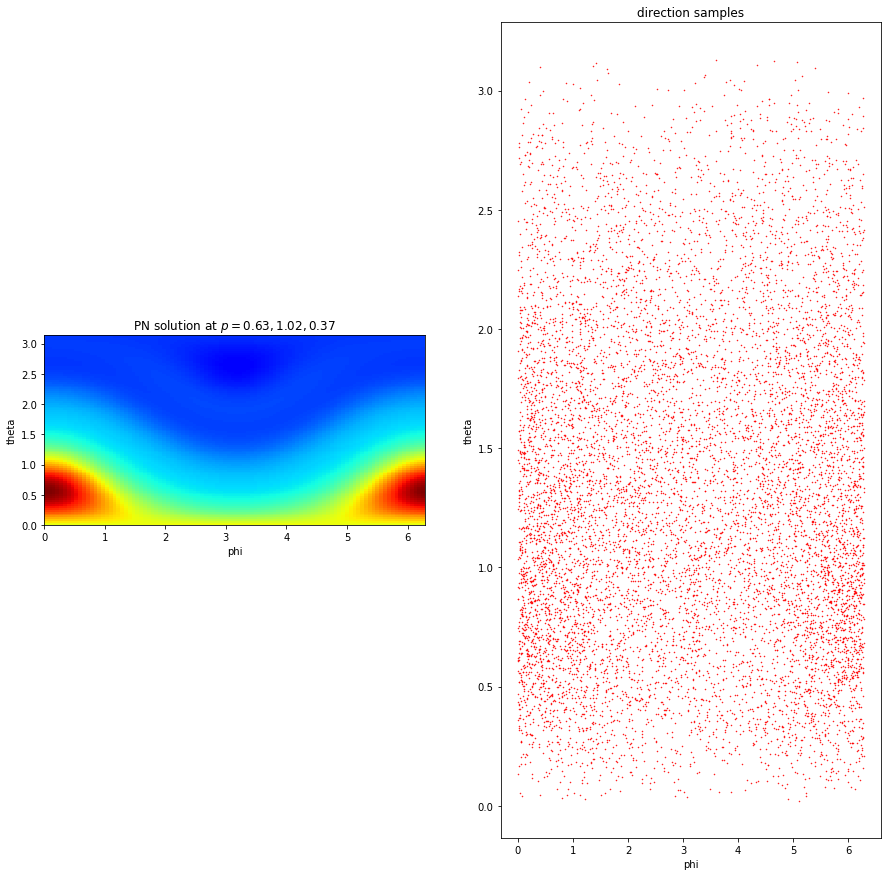

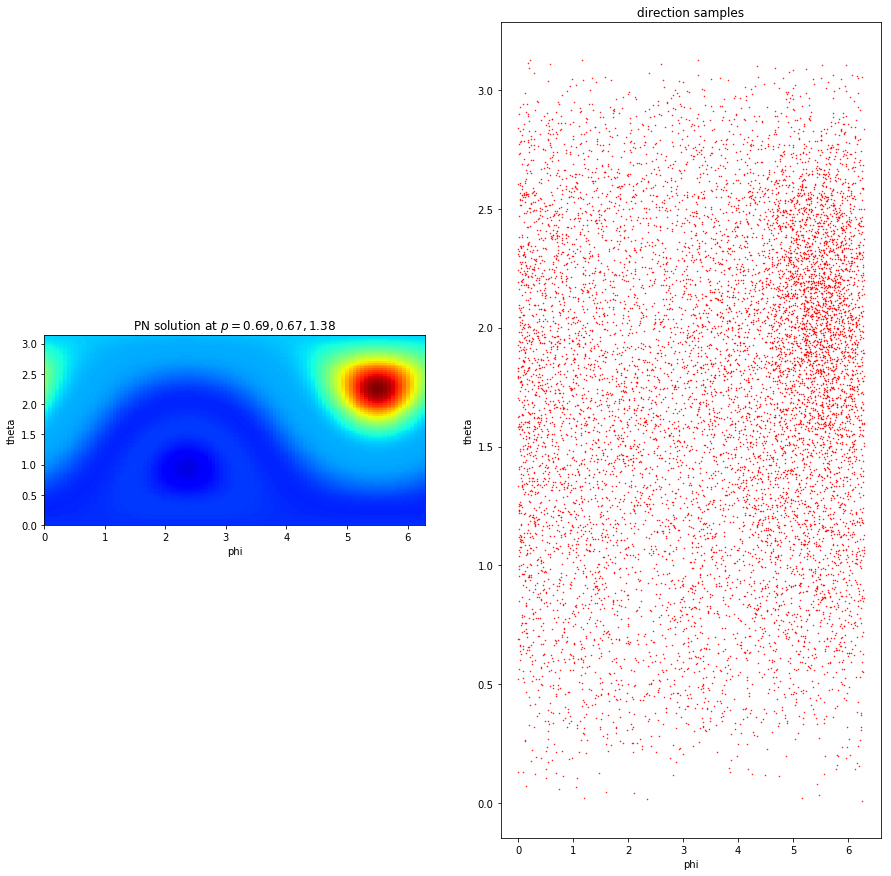

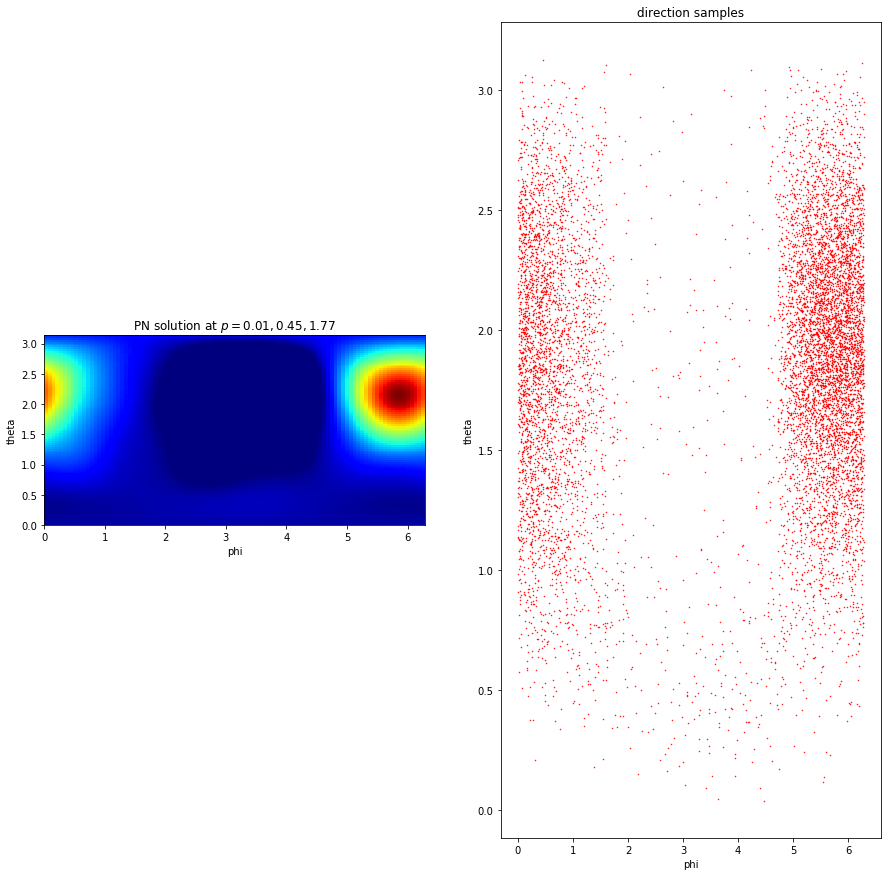

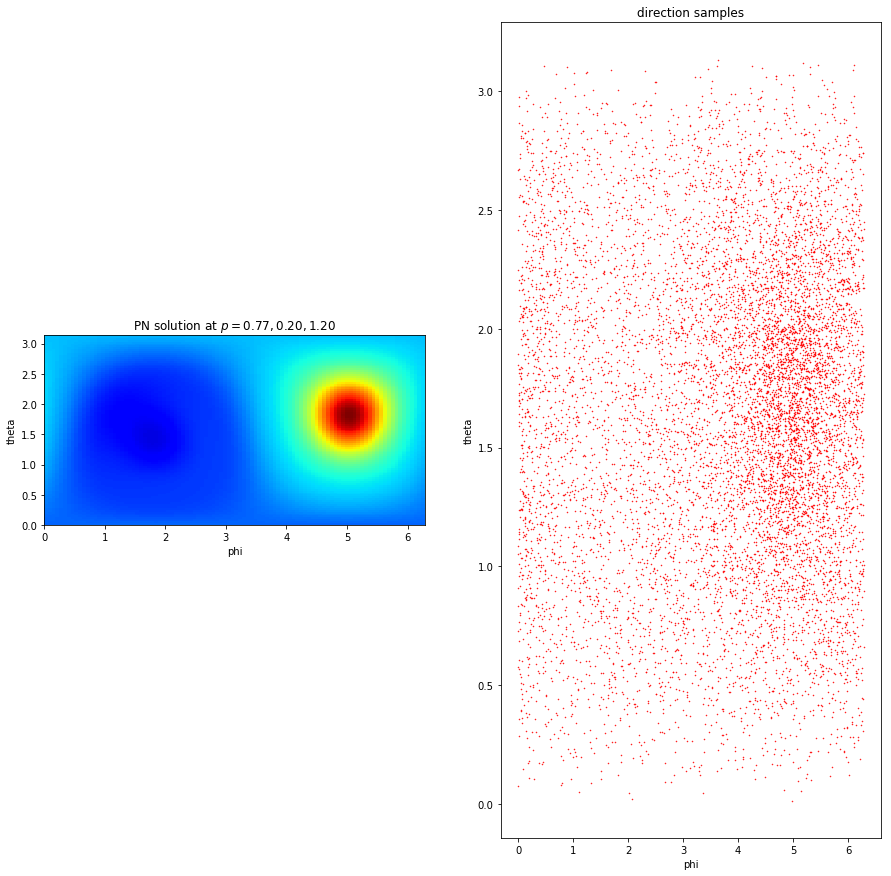

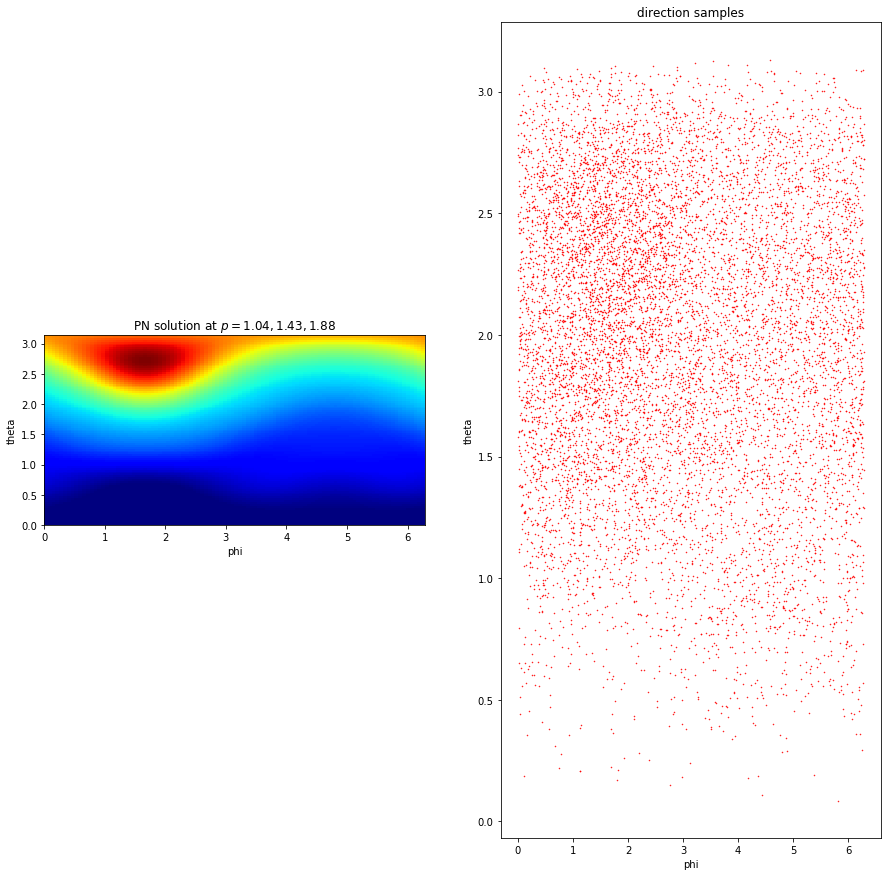

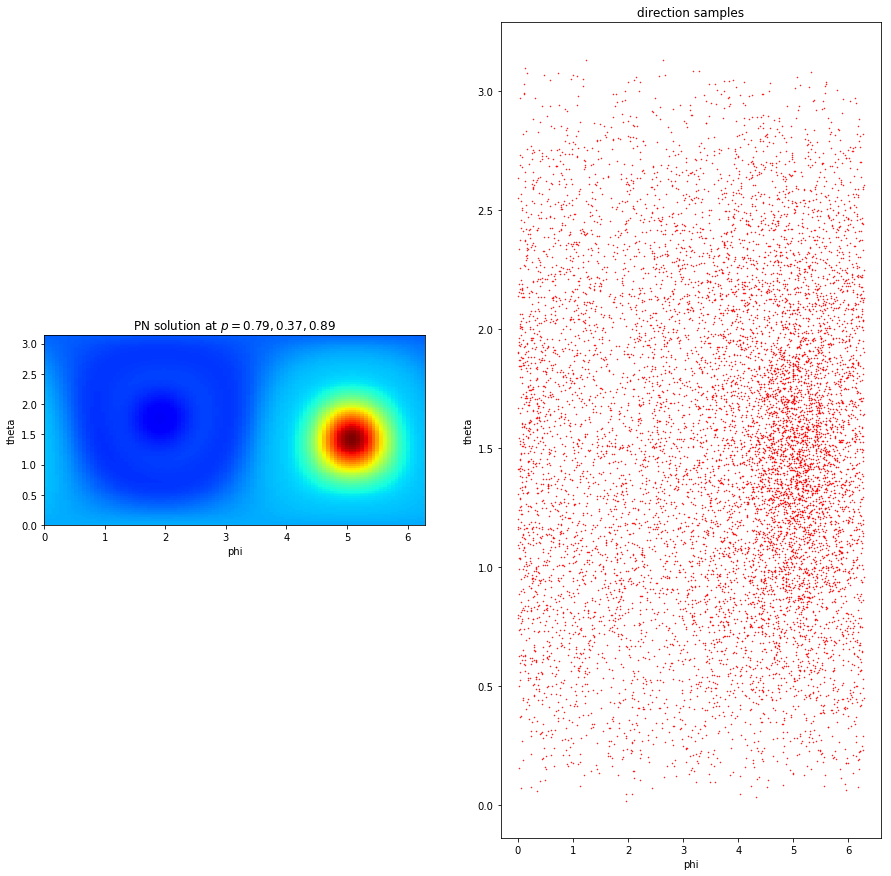

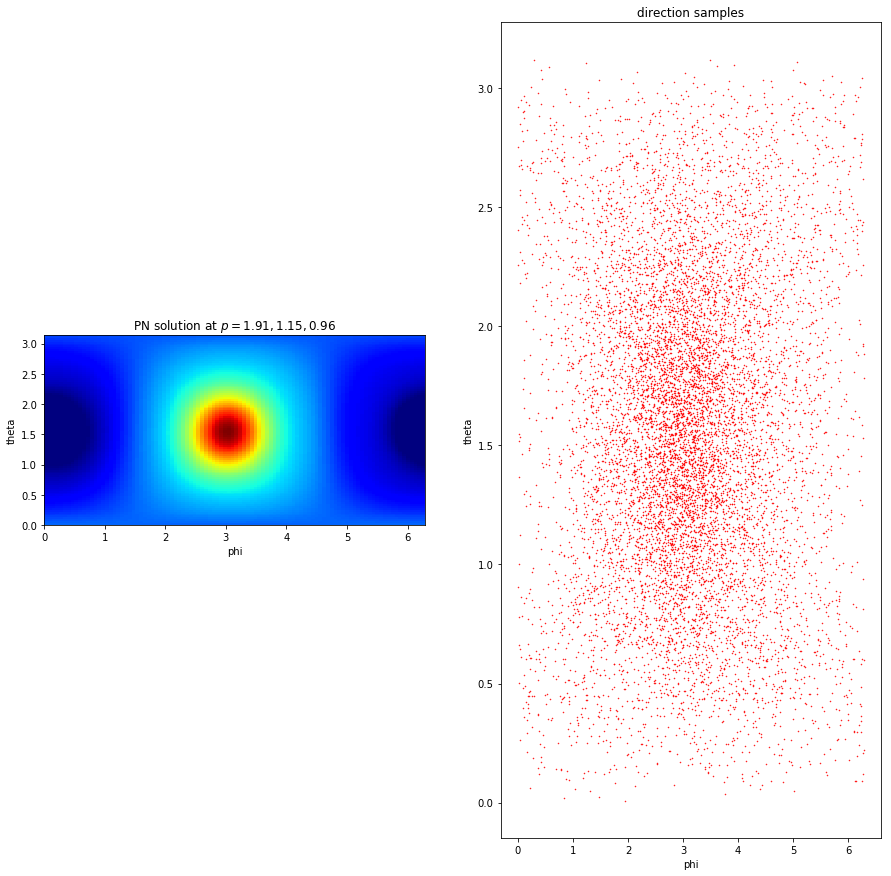

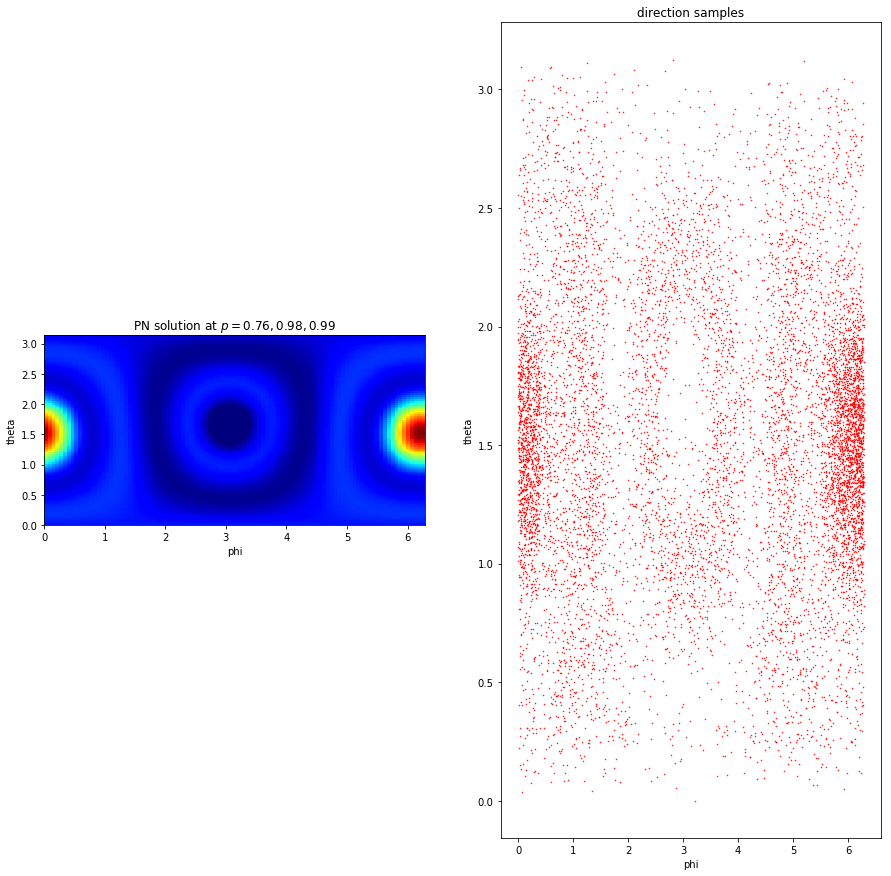

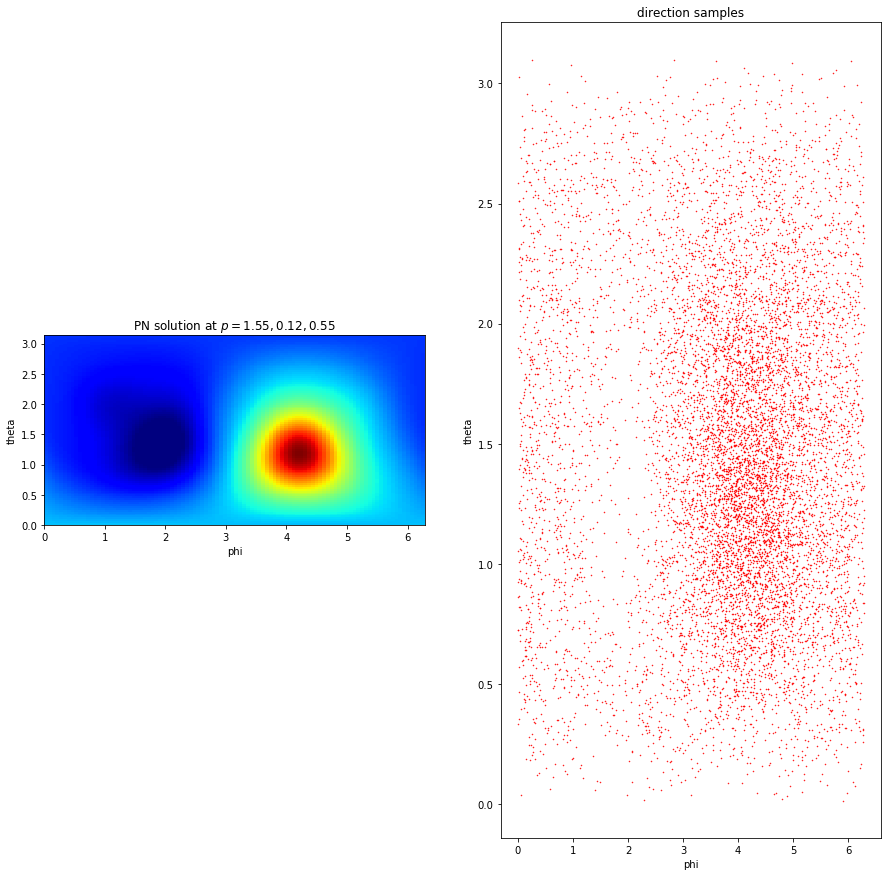

In [3]:
#pns = renderer.load_pnsolution( "results/pointsource/pointsource_p5.pns" )
pns = renderer.load_pnsolution( "c:/projects/epfl/epfl17/python/pnsolver/results/pointsource/pointsource_p5_2.pns" )
#pns = pns_solutions[4]
for i in range(10):
    random.seed(1233*i)
    pWS = np.array([random.random()*2.0, random.random()*2.0, random.random()*2.0])

    # visualize samples and the sampled sh function ------------------
    samples_theta = []
    samples_phi = []

    numSamples = 10000
    for i in range(numSamples):
        d, d_pdf = pns.sample(pWS, np.array([random.random(), random.random()]))
        d = -d
        theta, phi = util.sphericalCoordinates(d)
        samples_theta.append(theta)
        samples_phi.append(phi)
        #pass



    fig = plt.figure(figsize=(15,15));
    ax = fig.add_subplot(121)
    plt.title("PN solution at $p={:.2f}, {:.2f}, {:.2f}$".format(pWS[0], pWS[1], pWS[2]))
    img = plot_spherical_function( lambda theta, phi: clamped_sh(pns, theta, phi) )
    img_view = plt.imshow(img, origin='lower',zorder=1, interpolation="nearest", cmap='jet', vmin=0.0, vmax=np.max(img), extent=[0.0,2.0*np.pi,0.0,np.pi])
    plt.xlabel('phi')
    plt.ylabel('theta')
    #plt.scatter(samples_phi, samples_theta, c='r', label="sdda",zorder=2, marker='.', s=1.0)
    #divider = make_axes_locatable(ax)
    #cax = divider.append_axes("right", size="5%", pad=0.05)
    #plt.colorbar(img_view, cax=cax)

    ax = fig.add_subplot(122)
    plt.title("direction samples")
    #img_view = plt.imshow(img, origin='lower',zorder=1, interpolation="nearest", cmap='jet', vmin=0.0, vmax=np.max(img), extent=[0.0,2.0*np.pi,0.0,np.pi])
    plt.xlabel('phi')
    plt.ylabel('theta')
    plt.scatter(samples_phi, samples_theta, c='r', label="sdda",zorder=2, marker='.', s=1.0)

    #img = plot_spherical_function( lambda theta, phi: pns.pdf(pWS, -util.sphericalDirection(theta, phi)) )
    #img_view = plt.imshow(img, origin='lower',zorder=1, interpolation="nearest", cmap='jet', vmin=0.0, vmax=np.max(img), extent=[0.0,2.0*np.pi,0.0,np.pi])

    plt.show()

----------------------------------------

# Using direction sampling from PN-solution, instead of phase function sampling (importance sampling the direction, according to PN-solution)

In [35]:
img_simplept = renderer.load_image("c:/projects/epfl/epfl17/python/pnsolver/results/pointsource/fluence_at_1.7.exr").asMatrix()
img_pnispt = renderer.load_image("c:/projects/epfl/epfl17/python/pnsolver/results/pointsource/fluence_pnis_at_1.7.exr").asMatrix()

def MSE(Y, YH):
     return np.square(Y - YH).mean()
groundtruth = grosjean(0.7, sigma_t, albedo)
print( "MSE phase function sampling (equal sample count)={:.02f}".format(MSE( img_simplept, groundtruth ) ))
print( "MSE PNSH direction sampling (equal sample count)={:.02f}".format(MSE( img_pnispt, groundtruth ) ))

img_simplept = np.power(2.0, -4.0)*renderer.load_image("c:/projects/epfl/epfl17/python/pnsolver/results/pointsource/fluence_at_1.7.exr").asMatrix()
img_pnispt = np.power(2.0, -4.0)*renderer.load_image("c:/projects/epfl/epfl17/python/pnsolver/results/pointsource/fluence_pnis_at_1.7.exr").asMatrix()


MSE phase function sampling (equal sample count)=31.67
MSE PNSH direction sampling (equal sample count)=13.11


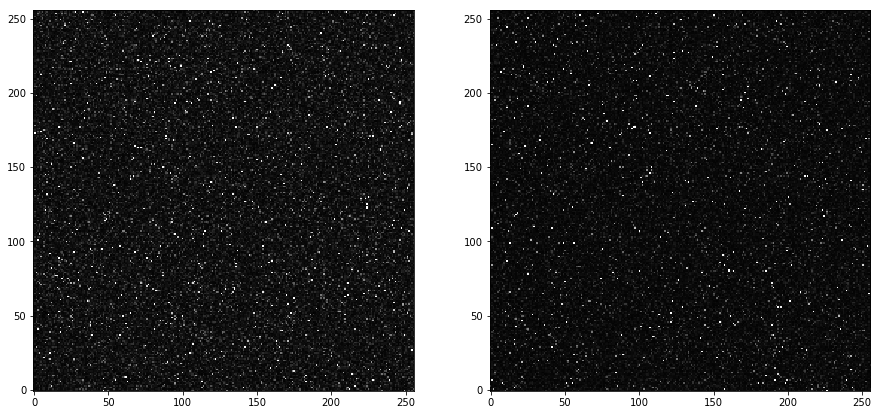

In [36]:
vmax = 1.0
fig = plt.figure(figsize=(15,15));
ax = fig.add_subplot(121)
#plt.title("PN solution at $p={:.2f}, {:.2f}, {:.2f}$".format(pWS[0], pWS[1], pWS[2]))
#img = plot_spherical_function( lambda theta, phi: clamped_sh(pns, theta, phi) )
img_view = plt.imshow(img_simplept, origin='lower',zorder=1, interpolation="nearest", cmap='gray', vmin=0.0, vmax=vmax)
#plt.xlabel('phi')
#plt.ylabel('theta')
#plt.scatter(samples_phi, samples_theta, c='r', label="sdda",zorder=2, marker='.', s=1.0)
#divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="5%", pad=0.05)
#plt.colorbar(img_view, cax=cax)

ax = fig.add_subplot(122)
#plt.title("direction samples")
img_view = plt.imshow(img_pnispt, origin='lower',zorder=1, interpolation="nearest", cmap='gray', vmin=0.0, vmax=vmax)
#plt.xlabel('phi')
#plt.ylabel('theta')
#plt.scatter(samples_phi, samples_theta, c='r', label="sdda",zorder=2, marker='.', s=1.0)

#img = plot_spherical_function( lambda theta, phi: pns.pdf(pWS, -util.sphericalDirection(theta, phi)) )
#img_view = plt.imshow(img, origin='lower',zorder=1, interpolation="nearest", cmap='jet', vmin=0.0, vmax=np.max(img), extent=[0.0,2.0*np.pi,0.0,np.pi])

plt.show()